<a id = "top"></a>

# Anomaly Detection
---

This notebook presents a couple methods of flagging highlights using anomaly detection techniques. When looking at a time series plot of the message per second data, potential highlights take the form of spikes in the ambient noise. This makes the data ideal for an anomaly detection analysis, where the highlights are the anomalies. The methods are lsited here, in order of complexity.

1. Z-Scores:

> This basic method looks at the magnitude of the spikes and assigns them a highlight flag if they pass a certain threshold. While simple, this technique works quite well and can accurately identify all of the most important clips, and it is also the fastest of the three, making this method great for quickly marking down a long vod. However, it does have some drawbacks, most of which arise from trying to analyse a smaller portion of video.

2. Markov Chains:

> This technique calculates the likelihood of the next value of the messages per second. In theory, highlights are thought to have a low probability of occuring. When such an event occurs, it is flagged as a highlight. This technique performs well at extracting smaller spikes from the ambient noise, but as a result may return many clips. This technique is slightly slower but great for marking down smaller segments of a vod, about 1 hour or less.

3. Latent Dirichlet Allocation:

> This method utilizes the content of the chat message as well as the message-per-second data. Using LDA allows for highlighting based on the topic being discussed in chat at any given time. Because this technique is more complex than the other two, it is separated into its own notebook.

**This Notebook:**

- [Preliminary EDA](#eda)
- [Z-Score Threshold Anomaly Detection](#zscore)
- [Markov Chain Anomaly Detection](#mc)
- [Latent Dirichlet Allocation Anomaly Detection](#lda)



**Other Notebooks:**

- [Data Gathering and Formatting](01_data_gathering.ipynb)
- [Topic Modeling](03_topic_modeling.ipynb)
- [Video Editing](04_video_editing.ipynb)

### Importing
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import highlighter as hl 
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

# Matplotlib has an issue with pandas datetime converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

In [2]:
time_series = pd.read_csv("../data/formatted/admiralbulldog_4_30_mps.csv", 
                          index_col = "Unnamed: 0",
                          parse_dates = True).rename(columns = {"0": "mps"})

time_series.head()

,mps
2019-04-30 08:57:00,3
2019-04-30 08:57:01,1
2019-04-30 08:57:02,2
2019-04-30 08:57:03,3
2019-04-30 08:57:04,2


In [3]:
# Getting the chat log for just one game from the stream.
# Game starts at 10:29am and ends at 11:13

game = time_series["2019-04-30 10:29:26":"2019-04-30 11:14:00"]

game.head()

,mps
2019-04-30 10:29:26,1
2019-04-30 10:29:27,0
2019-04-30 10:29:28,0
2019-04-30 10:29:29,0
2019-04-30 10:29:30,0


<a id = "eda"></a>
## Plotting
---

[Back to top](#top)

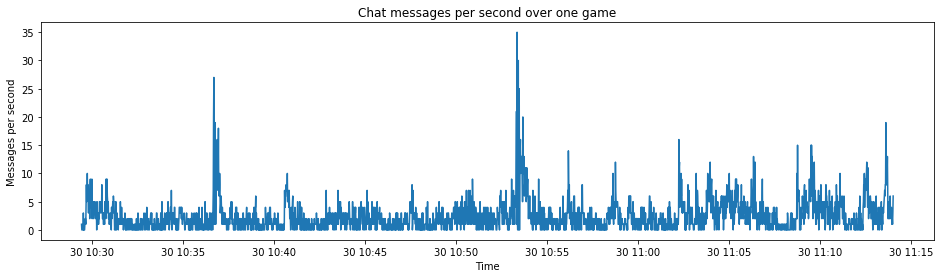

In [4]:
plt.figure(figsize = (16,4))

plt.plot(game)

plt.ylabel("Messages per second")
plt.xlabel("Time")
plt.title("Chat messages per second over one game")

plt.savefig("../assets/images/mps_one_game.png");

> This plot shows the general shape of the message-per-second data. Periods of relatively low activity are broken up by large spikes, often triggered in reaction to something happening in the stream itself. The chat resembles a crowd at a sports stadium, where the murmur of the crowd is broken up by loud cheering and yelling when the home team makes an outstanding play.

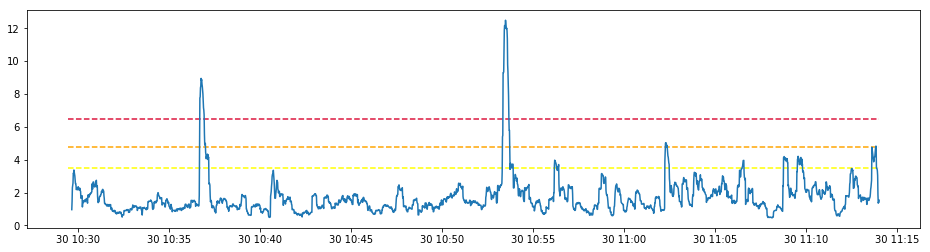

In [5]:
plt.figure(figsize = (16,4))
plt.plot(game["mps"].rolling(15).std())

plt.hlines(6.5, 
           game.index.min(), 
           game.index.max(), 
           colors = "crimson", 
           linestyles = "dashed")

plt.hlines(4.75, 
           game.index.min(), 
           game.index.max(), 
           colors = "orange", 
           linestyles = "dashed")

plt.hlines(3.5, 
           game.index.min(), 
           game.index.max(), 
           colors = "yellow", 
           linestyles = "dashed")

plt.yticks([0, 2, 4, 6, 8, 10, 12])

plt.savefig("../assets/images/mps_scaled_one_game.png");

> This plot shows the rolling standard deviation of the message-per-second data. Standard deviation is a measure of spread, which makes it ideal for my purposes as the spikes in MPS can be throught of as periods of increased spread. At low sample sizes (i.e `.rolling(less than 15)`), standard deviation is very sensitive to outliers, which again makes it very ideal for detecting outliers.

<a id = "zscore"></a>
## Z-Score Anomaly Detection
---

This method of anomaly detection is very straightforward, it is simply scaling the data and then moving a threshold up or down until you have the desired length of video that you want in your highlight reel. While simple, this method is quite effective, although it has some drawbacks that are addressed here, and subsequently fixed in the Markov Chain Anomaly Detection section.

[Back to top](#top)

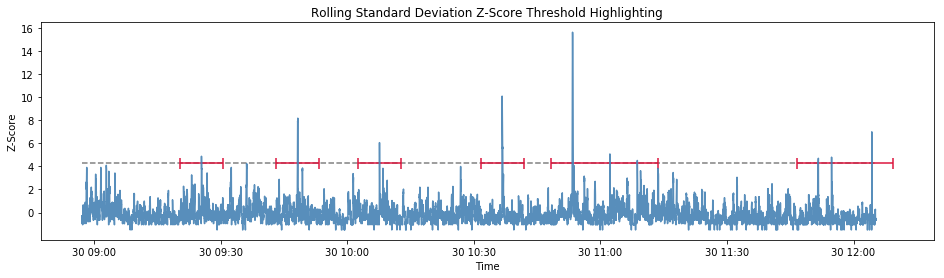

In [6]:
thresh = 4.25

time_series["highlight"] = hl.highlight_by_stdev(time_series, threshold = thresh)

stdev = time_series["mps"].rolling(5).std()
z_score = stdev - stdev.mean() / stdev.std()

plt.figure(figsize = (16,4))
plt.plot(z_score,
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           time_series.index.min(), 
           time_series.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(time_series, before_time = 300, after_time = 300):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.5, 
               thresh + 0.5, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.5, 
               thresh + 0.5, 
               colors = "crimson")
    
plt.yticks(range(0, 17, 2))

plt.title("Rolling Standard Deviation Z-Score Threshold Highlighting")
plt.xlabel("Time")
plt.ylabel("Z-Score")
    
plt.savefig("../assets/images/zscore_threshold.png");

> This image shows the intuition behind this method of highlighting. As the threshold is lowered, more spikes are added to the amount of clips generated. If the start and end of a clip overlap, the two will be combined into one long clip. Note that the length of the clips has been expanded for demonstration purposes.

In [7]:
# Testing highlighter.py's z-score threshold function

time_series["highlight"] = hl.highlight_by_stdev(time_series, threshold = 4)

time_series.head()

,mps,highlight
2019-04-30 08:57:00,3,0
2019-04-30 08:57:01,1,0
2019-04-30 08:57:02,2,0
2019-04-30 08:57:03,3,0
2019-04-30 08:57:04,2,0


In [8]:
# Testing the timestamp method of finding the start and end times.

hl.get_highlights_timestamp(time_series)

[(Timestamp('2019-04-30 09:02:37'), Timestamp('2019-04-30 09:03:07')),
 (Timestamp('2019-04-30 09:25:11'), Timestamp('2019-04-30 09:25:42')),
 (Timestamp('2019-04-30 09:35:53'), Timestamp('2019-04-30 09:36:26')),
 (Timestamp('2019-04-30 09:47:57'), Timestamp('2019-04-30 09:48:32')),
 (Timestamp('2019-04-30 10:07:23'), Timestamp('2019-04-30 10:07:54')),
 (Timestamp('2019-04-30 10:36:26'), Timestamp('2019-04-30 10:37:06')),
 (Timestamp('2019-04-30 10:53:04'), Timestamp('2019-04-30 10:53:57')),
 (Timestamp('2019-04-30 11:01:59'), Timestamp('2019-04-30 11:02:32')),
 (Timestamp('2019-04-30 11:08:30'), Timestamp('2019-04-30 11:09:01')),
 (Timestamp('2019-04-30 11:51:21'), Timestamp('2019-04-30 11:51:55')),
 (Timestamp('2019-04-30 11:54:33'), Timestamp('2019-04-30 11:55:03')),
 (Timestamp('2019-04-30 12:04:05'), Timestamp('2019-04-30 12:04:39'))]

In [9]:
hl.clip_stats(hl.get_highlights_timestamp(time_series))

12 distinct clips
6:55 total minutes of video


In [10]:
# Testing the 0-based index method of finding the start and end times.

hl.get_highlights_index(time_series.reset_index(drop = True))

[(337, 367),
 (1691, 1722),
 (2333, 2366),
 (3057, 3092),
 (4223, 4254),
 (5966, 6006),
 (6964, 7017),
 (7499, 7532),
 (7890, 7921),
 (10461, 10495),
 (10653, 10683),
 (11225, 11259)]

In [11]:
hl.clip_stats(hl.get_highlights_index(time_series.reset_index(drop = True)))

12 distinct clips
6:55 total minutes of video


### Single game highlights with z-scores

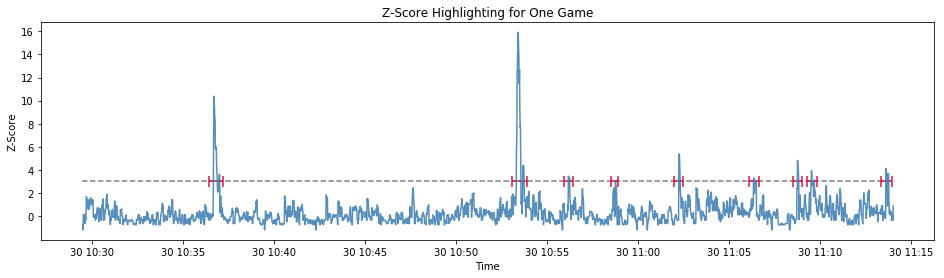

In [12]:
thresh = 3

game["highlight"] = hl.highlight_by_stdev(game, threshold = thresh)

stdev = game["mps"].rolling(5).std()
z_score = stdev - stdev.mean() / stdev.std()

plt.figure(figsize = (16,4))
plt.plot(z_score,
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, before_time = 15, after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.5, 
               thresh + 0.5, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.5, 
               thresh + 0.5, 
               colors = "crimson")

plt.yticks(range(0, 17, 2))

plt.title("Z-Score Highlighting for One Game")
plt.xlabel("Time")
plt.ylabel("Z-Score");

plt.savefig("../assets/images/zscore_threshold_single_game.png");

> This shows the z-score highlighting for one game, a total duration of about 45 minutes. Note that at a threshold of 3, there is only one clip in the first 50% of the game. There are some smaller spikes in between the two large spikes that might help to provide some context for the rest of the reel. However, were the threshold made any lower, it might start to pick up the random noise near the end of the game, which would result in many clips being made, or a few clips that are very long. Either solution may be fine depending on your preferences, but it might be possible to achieve a middle ground.

In [13]:
game["highlight"] = hl.highlight_by_stdev(game, threshold = 3)

hl.clip_stats(hl.get_highlights_index(game.reset_index(), 
                                      before_time = 15, 
                                      after_time = 10))

9 distinct clips
5:8 total minutes of video


In [14]:
game[["highlight"]].to_csv("../data/highlighted/admiralbulldog_4_30_zscore.csv")

<a id = "mc"></a>
## Markov Chain Anomaly Detection
---

This method of highlighting was designed to address the issues that arise from just z-score threshold highlighting, discussed in the image annotation just above this section header. To emphasize some of the smaller spikes, I used the Markov property to calculate the probability of the next value of messages per second, given the current value. To do this, I used a Gaussian distribution with a mean at the current value of MPS, then calculated the probability of next value using the probability density function. 

As an example, say that the current messages per second is 3. If the next value is 4, then there will be a high probability of this event occuring. The mean of the Guassian distribution is then updated to 4. However, if the next value is 15, there is a very low probability of this event happening, and it will be flagged by the highlighter.

[Back to top](#top)

### Reimporting
---

In [15]:
time_series = pd.read_csv("../data/formatted/admiralbulldog_4_30_mps.csv", 
                          index_col = "Unnamed: 0",
                          parse_dates = True).rename(columns = {"0": "mps"})

time_series.head()

,mps
2019-04-30 08:57:00,3
2019-04-30 08:57:01,1
2019-04-30 08:57:02,2
2019-04-30 08:57:03,3
2019-04-30 08:57:04,2


In [16]:
# This algorithm will calculate the probability 
# of "mps" using the Markov Property

# scale the data
stdev = time_series["mps"].rolling(5).std()
z_score = stdev - stdev.mean() / stdev.std()

# Initial mean and stdev for the normal distribution
# are based off the scaled data.
mu = z_score.mean()
sig = z_score.std()

mc_prob = []

# Iterate through every second and calculate how likely 
# the current "mps" is, given the last value of "mps"
# using a normal distribution.
for score in z_score:
    
    mc_prob.append(scipy.stats.norm(mu, sig).pdf(score))
    mu = score
    
mc_prob = pd.Series(mc_prob, index = time_series.index)

time_series["mc_prob"] = mc_prob

time_series.head(6)

,mps,mc_prob
2019-04-30 08:57:00,3,NaN
2019-04-30 08:57:01,1,NaN
2019-04-30 08:57:02,2,NaN
2019-04-30 08:57:03,3,NaN
2019-04-30 08:57:04,2,NaN
2019-04-30 08:57:05,0,0.395847


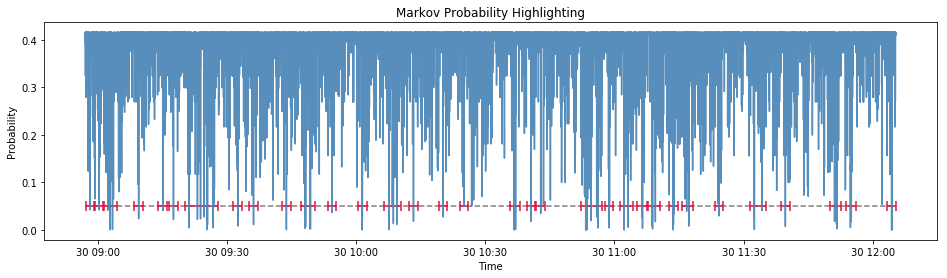

In [17]:
thresh = 0.05

time_series["highlight"] = (time_series["mc_prob"] <= thresh).astype(int)



plt.figure(figsize = (16,4))
plt.plot(time_series["mc_prob"],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           time_series.index.min(), 
           time_series.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(time_series, before_time = 60, after_time = 60):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")

    plt.vlines(clip[0], 
               thresh - 0.01, 
               thresh + 0.01, 
               colors = "crimson")

    plt.vlines(clip[1], 
               thresh - 0.01, 
               thresh + 0.01, 
               colors = "crimson")

plt.title("Markov Probability Highlighting")
plt.xlabel("Time")
plt.ylabel("Probability");

> This plot shows the probabilities of the next value of messages-per-second, given the current messages-per-sec. Right away, it is easy to tell that this method of highlighting produces many more clips than z-score thresholds; to avoid having an extremely long highlight reel, you may want to decrease the length of each clip, focus on a smaller segment of the video.

In [18]:
time_series["highlight"] = hl.highlight_by_probability(time_series)

time_series.head()

,mps,mc_prob,highlight
2019-04-30 08:57:00,3,NaN,0
2019-04-30 08:57:01,1,NaN,0
2019-04-30 08:57:02,2,NaN,0
2019-04-30 08:57:03,3,NaN,0
2019-04-30 08:57:04,2,NaN,0


In [19]:
hl.clip_stats(hl.get_highlights_timestamp(time_series, 
                                          before_time = 10,
                                          after_time = 10))

50 distinct clips
19:54 total minutes of video


In [20]:
# Getting the chat log for just one game from the stream.
# Game starts at 10:29am and ends at 11:13

time_series = pd.read_csv("../data/formatted/admiralbulldog_4_30_mps.csv", 
                          index_col = "Unnamed: 0",
                          parse_dates = True).rename(columns = {"0": "mps"})

game = time_series["2019-04-30 10:29:26":"2019-04-30 11:14:00"]

game.head()

,mps
2019-04-30 10:29:26,1
2019-04-30 10:29:27,0
2019-04-30 10:29:28,0
2019-04-30 10:29:29,0
2019-04-30 10:29:30,0


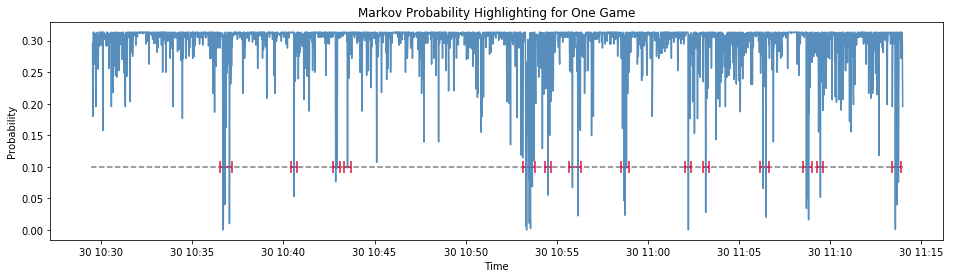

In [21]:
thresh = 0.1

stdev = game["mps"].rolling(5).std()
z_score = stdev - stdev.mean() / stdev.std()

mu = z_score.mean()
sig = z_score.std()

mc_prob = []

for score in z_score:
    mc_prob.append(scipy.stats.norm(mu, sig).pdf(score))
    mu = score
    
mc_prob = pd.Series(mc_prob, index = game.index)

game["mc_prob"] = mc_prob

game["highlight"] = (game["mc_prob"] <= thresh).astype(int)



plt.figure(figsize = (16,4))
plt.plot(game["mc_prob"],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, before_time = 10, after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")

    plt.vlines(clip[0], 
               thresh - 0.01, 
               thresh + 0.01, 
               colors = "crimson")

    plt.vlines(clip[1], 
               thresh - 0.01, 
               thresh + 0.01, 
               colors = "crimson")



plt.title("Markov Probability Highlighting for One Game")
plt.xlabel("Time")
plt.ylabel("Probability");

plt.savefig("../assets/images/markov_probability_single_game.png");

> This plot shows how the smaller spikes, especially those between 10:40 and 10:50, are exaggerated to the point that they can be picked up by the highlighter without the random noise towards the end being picked up as well.

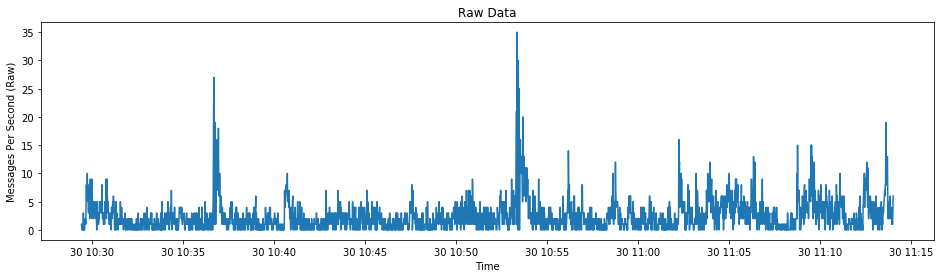

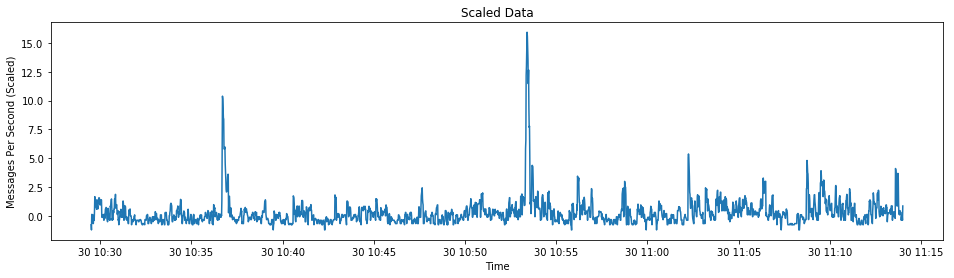

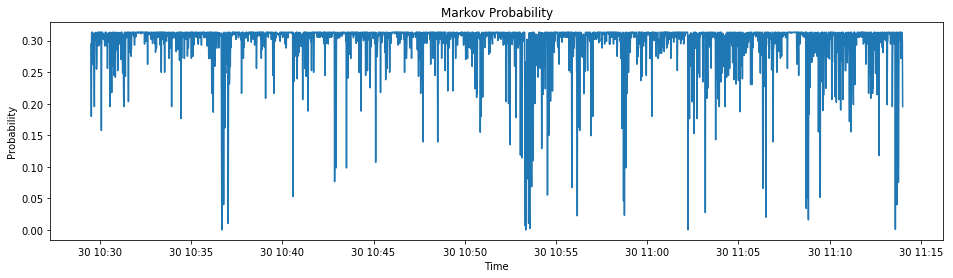

In [22]:
# raw data

plt.figure(figsize = (16,4))
plt.plot(game["mps"])
plt.ylabel("Messages Per Second (Raw)")
plt.xlabel("Time")
plt.title("Raw Data")
plt.savefig("../assets/images/comparison_raw.png")

# scaled data

plt.figure(figsize = (16,4))
plt.plot(z_score)
plt.ylabel("Messages Per Second (Scaled)")
plt.xlabel("Time")
plt.title("Scaled Data")
plt.savefig("../assets/images/comparison_scaled.png")


# markov pdf, scaled

plt.figure(figsize = (16,4))
plt.plot(game["mc_prob"])
plt.ylabel("Probability")
plt.xlabel("Time")
plt.title("Markov Probability")
plt.savefig("../assets/images/comparison_markov.png");

> These three plots show a comparison between raw data, scaled data, and the Markov probability of the data. Note that the shape of the raw and scaled are roughly similar, but the probability data gets very spiky in the areas of high mps; in particular, the smaller spikes have been greatly accentuated. Also note that the direction of the data has been flipped, with the outliers in probability being close to zero rather than being very large.

In [23]:
game["highlight"] = hl.highlight_by_probability(game, sensitivity = 0.1)

hl.clip_stats(hl.get_highlights_index(game.reset_index(), 
                                      before_time = 10, 
                                      after_time = 10))

14 distinct clips
6:20 total minutes of video


In [24]:
game[["highlight"]].to_csv("../data/highlighted/admiralbulldog_4_30_mc.csv")

<a id = "lda"></a>
## Latent Dirichlet Allocation Anomaly Detection
---

Anomaly detection with LDA is a big enough topic that it has its own notebook, check it out here: [Topic Modeling](03_topic_modeling.ipynb)

---
[Back to top](#top)